In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# dataset. positive/negative label
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/jacky/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

In [3]:
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

inverted_word_index = dict((i, word) for (word, i) in word_index.items())


def decode_review(text_arr):
    """
    convert int array to words
    """
    return ' '.join(inverted_word_index[i] for i in text_arr)

In [4]:
print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

影评——即整数数组必须在输入神经网络之前转换为张量。（调用 tf 接口即可）

填充数组来保证输入数据具有相同的长度（使用 pad_sequences() 函数），然后创建一个大小为 max_length * num_reviews 的整型张量。

In [5]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=256, padding='post',
                                                           value=word_index["<PAD>"])
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=256, padding='post',
                                                          value=word_index["<PAD>"])

In [6]:
# model

model = tf.keras.models.Sequential([
    # 特征(10000个单词)转为嵌入向量/稀疏特征转化为稠密特征
    tf.keras.layers.Embedding(10000, 16),
    # 简化输出
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


2021-08-11 12:59:50.689873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-11 12:59:50.690368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [9]:
history = model.fit(partial_x_train, partial_y_train,
                    batch_size=512, epochs=40,
                    validation_data=(x_val, y_val),
                    verbose=1)

2021-08-11 12:59:50.962493: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-11 12:59:50.965504: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-11 12:59:51.123498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6916 - accuracy: 0.5953 - val_loss: 0.6893 - val_accuracy: 0.6854
Epoch 2/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6885 - accuracy: 0.7363

2021-08-11 12:59:51.809688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 22ms/step - loss: 0.6850 - accuracy: 0.7239 - val_loss: 0.6804 - val_accuracy: 0.7368
Epoch 3/40
30/30 [==============================] - 1s 24ms/step - loss: 0.6716 - accuracy: 0.7643 - val_loss: 0.6638 - val_accuracy: 0.7532

In [10]:
results = model.evaluate(test_data, test_labels, verbose=1)

782/782 [==============================] - 5s 6ms/step - loss: 0.3315 - accuracy: 0.8728

对history的`loss`和`accuracy`进行绘图

In [11]:
import matplotlib.pyplot as plt

# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
print(history.history.keys())

history_dict = history.history

loss = history_dict['loss']
acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)  # (1, 41)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


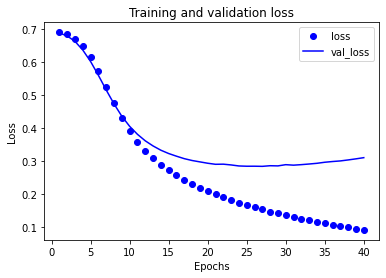

In [12]:
# plot v.绘制图表, figure n.图形
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
# legend n.说明(右上角那个)
plt.legend()

plt.show()

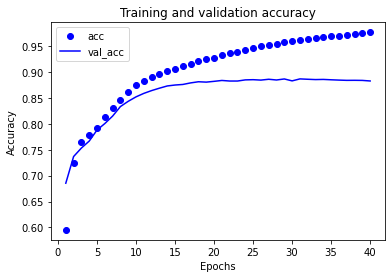

In [13]:
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()
plt.show()

验证过程的损失值（loss）与准确率（accuracy）的情况却并非如此——它们似乎在 20 个 epoch 后达到峰值。这是**过拟合**的一个实例：模型在训练数据上的表现比在以前从未见过的数据上的表现要更好。在此之后，模型过度优化并学习特定于训练数据的表示，而不能够泛化到测试数据。

对于这种特殊情况，我们可以通过在 20 个左右的 epoch 后停止训练来避免过拟合。稍后，您将看到如何通过**回调**自动执行此操作。